# Predicting cause of death from PHMRC VA text narratives using classic NLP methods. 
## Naive Bayes, SVM, K Nearest Neighbor, rebalancing with SMOTE+ENN and reweighting
References: <br>
zhou 2023 circumstances preceding female firearm suicide https://mental.jmir.org/2023/1/e49359/ <br>
https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34 <br>
https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

In [75]:
import pandas as pd
import numpy as np
import random 
import matplotlib.pyplot as plt
import tensorflow as tf
import imblearn
import statsmodels.api as sm
from tqdm.auto import tqdm
from transformers import BertTokenizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from collections import defaultdict, Counter

import warnings
warnings.filterwarnings("ignore")

## Load data as Trinity

In [192]:
# covariates with just age
Test_X_covariates = pd.read_csv('covariates.csv')
Test_X_covariates = Test_X_covariates['age_yr']

# # covariates with age and education
# Test_X_covariates = pd.read_csv('covariates.csv')

# predictions from 3 NLP classifiers plus the true labels (Test_Y)
predictions_df = pd.read_csv('predictions.csv')

Test_Y = predictions_df['Test_Y']
predictions_NB = predictions_df['predictions_NB']
predictions_SVM = predictions_df['predictions_SVM']
predictions_KNN = predictions_df['predictions_KNN']

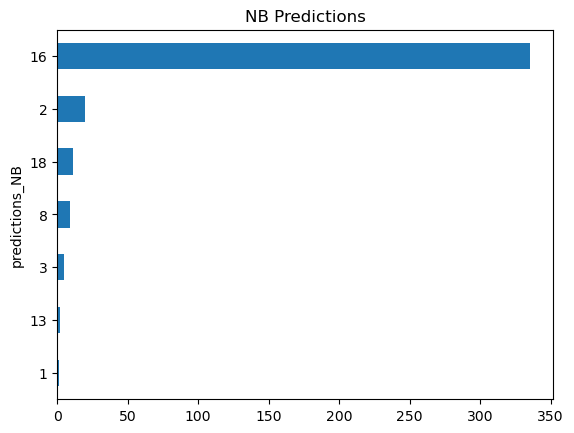

In [193]:
pd.Series(predictions_NB).value_counts().plot.barh(title='NB Predictions').invert_yaxis()

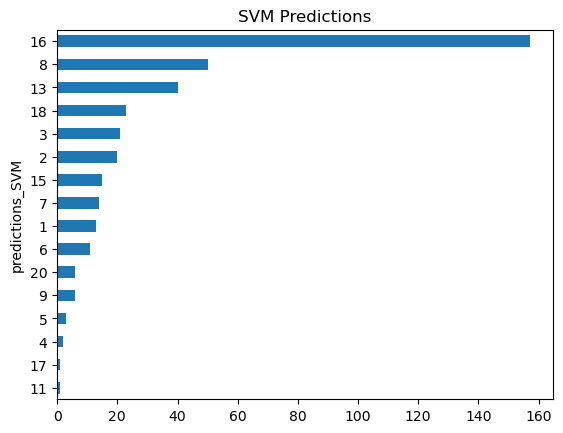

In [194]:
pd.Series(predictions_SVM).value_counts().plot.barh(title='SVM Predictions').invert_yaxis()

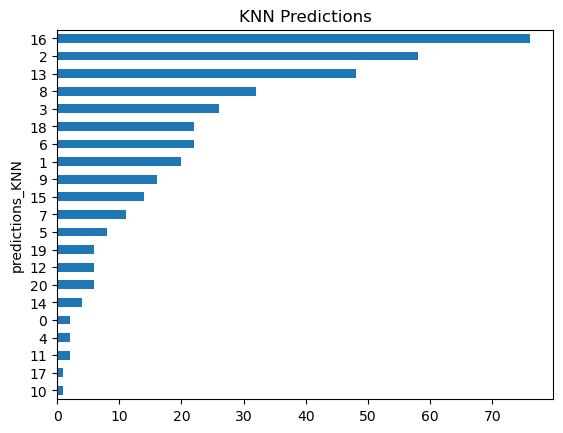

In [195]:
pd.Series(predictions_KNN).value_counts().plot.barh(title='KNN Predictions').invert_yaxis()

## sklearn for Multinomial Logistic Regression 

In [196]:
# # using sklearn for the multinomial logistic regression
# model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# NB_baseline = model.fit(np.array(list(Test_X_covariates)).reshape(-1,1), predictions_NB)
# SVM_baseline = model.fit(np.array(list(Test_X_covariates)).reshape(-1,1), predictions_SVM)
# KNN_baseline = model.fit(np.array(list(Test_X_covariates)).reshape(-1,1), predictions_KNN)

## statsmodels.api for the multinomial linear regression


In [197]:
# Add a constant term to the features for the intercept
Test_X_covariates_constant = sm.add_constant(np.array(Test_X_covariates).reshape(-1,1))

# Fit the multinomial logistic regression models using Statsmodels

# DOUBLE CHECK 0 IS REFERENCE CLASS CATEGORY

NB_baseline = sm.MNLogit(predictions_NB, Test_X_covariates_constant, check_rank=True).fit(method='bfgs')
SVM_baseline = sm.MNLogit(predictions_SVM, Test_X_covariates_constant, check_rank=True).fit(method='bfgs')
KNN_baseline = sm.MNLogit(predictions_KNN, Test_X_covariates_constant, check_rank=True).fit(method='bfgs')

         Current function value: 0.538097
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
         Current function value: 1.968707
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
         Current function value: 2.477432
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


In [198]:
print(NB_baseline.summary())

                          MNLogit Regression Results                          
Dep. Variable:         predictions_NB   No. Observations:                  383
Model:                        MNLogit   Df Residuals:                      371
Method:                           MLE   Df Model:                            6
Date:                Fri, 09 Feb 2024   Pseudo R-squ.:                 0.04083
Time:                        11:23:18   Log-Likelihood:                -206.09
converged:                      False   LL-Null:                       -214.86
Covariance Type:            nonrobust   LLR p-value:                  0.007475
 predictions_NB=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.8099      1.118      0.724      0.469      -1.382       3.002
x1                    0.2697      0.241      1.121      0.262      -0.202       0.742
------------------------

In [158]:
print(SVM_baseline.summary())

                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                  383
Model:                        MNLogit   Df Residuals:                      353
Method:                           MLE   Df Model:                           15
Date:                Fri, 09 Feb 2024   Pseudo R-squ.:                 0.03538
Time:                        11:05:40   Log-Likelihood:                -754.01
converged:                      False   LL-Null:                       -781.67
Covariance Type:            nonrobust   LLR p-value:                 1.581e-06
       y=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1153      0.705      1.583      0.113      -0.266       2.496
x1            -0.1521      0.101     -1.511      0.131      -0.349       0.045
----------------------------------------------------

In [159]:
print(KNN_baseline.summary())

                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                  383
Model:                        MNLogit   Df Residuals:                      343
Method:                           MLE   Df Model:                           20
Date:                Fri, 09 Feb 2024   Pseudo R-squ.:                 0.02162
Time:                        11:05:42   Log-Likelihood:                -948.86
converged:                      False   LL-Null:                       -969.83
Covariance Type:            nonrobust   LLR p-value:                  0.002814
       y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6516      1.309     -0.498      0.619      -3.216       1.913
x1             0.6859      0.438      1.566      0.117      -0.173       1.545
----------------------------------------------------